In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.api import VAR

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [2]:
data = pd.read_csv("dataset/timeseries.csv")
data

,Year,Temperature,Annual CO2 Emissions,Annual MH4 Emissions,Annual NiO Emissions
0,1961,0.163053,2.779522e+10,1.521873e+10,4.045673e+09
1,1962,-0.013476,2.877933e+10,1.550482e+10,4.181061e+09
2,1963,-0.006043,3.032081e+10,1.591023e+10,4.315127e+09
3,1964,-0.070059,3.194596e+10,1.627464e+10,4.467189e+09
4,1965,-0.247027,3.339014e+10,1.675168e+10,4.639234e+09
...,...,...,...,...,...
57,2018,1.302113,1.078831e+11,3.058126e+10,8.605265e+09
58,2019,1.443061,1.086966e+11,3.089436e+10,8.649985e+09
59,2020,1.552038,1.038568e+11,3.104839e+10,8.744636e+09
60,2021,1.343531,1.092707e+11,3.145000e+10,8.897455e+09


In [3]:
# Drop the last row from the DataFrame
last_row_index = data.index[-1]
data = data.drop(index=last_row_index)

In [4]:
features = ['Annual CO2 Emissions','Annual MH4 Emissions','Annual NiO Emissions']
target = ['Temperature']

In [9]:
X = data[features].values  # Input features
y = data[target].values  # Target variable

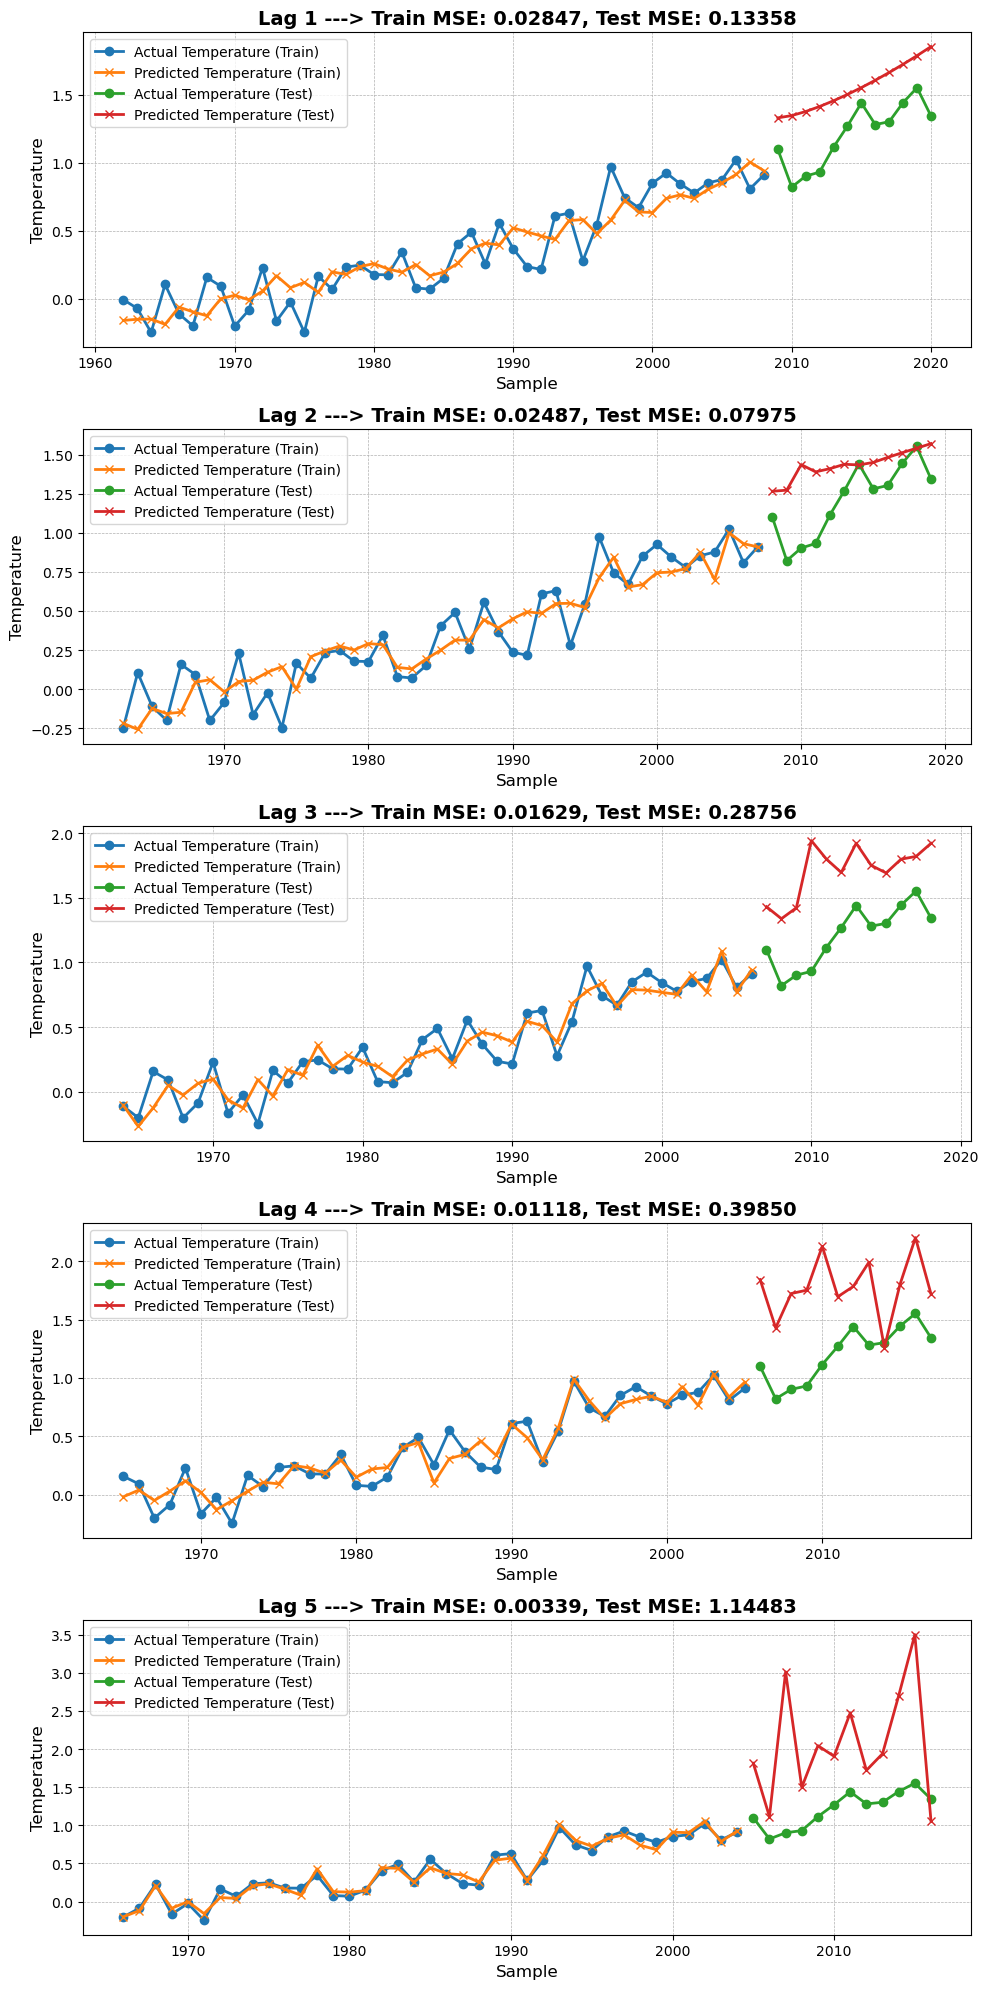

In [56]:
# Define the list of lags to consider
lags = [1, 2, 3, 4, 5]

# Create subplots with len(lags) rows and 1 column, and set the figure size
fig, ax = plt.subplots(len(lags), 1, figsize=(10, 20))

# Loop through each lag value and perform the VAR modeling and predictions
for lag in lags:
    # Create lagged input and output data
    X_lagged = np.zeros((len(X) - lag, lag * X.shape[1]))
    y_lagged = np.zeros(len(y) - lag)

    for i in range(lag, len(X)):
        X_lagged[i - lag] = X[i - lag:i].flatten()
        y_lagged[i - lag] = y[i]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_lagged, test_size=0.2, shuffle=False)

    # Normalize the input features X_train and X_test using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create and fit the VAR model
    var_model = VAR(np.concatenate((X_train_scaled, y_train.reshape(-1, 1)), axis=1))
    var_results = var_model.fit(maxlags=lag)

    # Prepare the lagged endogenous data for training and test predictions
    lagged_endog_train = np.concatenate((X_train_scaled[-lag:], y_train[-lag:].reshape(-1, 1)), axis=1)
    lagged_endog_test = np.concatenate((X_test_scaled[-lag:], y_test[-lag:].reshape(-1, 1)), axis=1)

    # Make predictions on the training set
    y_pred_train = var_results.fittedvalues[:, -1]
    mse_train = mean_squared_error(y_train[lag:], y_pred_train)

    # Make predictions on the test set
    y_pred_test = var_results.forecast(y=lagged_endog_test, steps=len(y_test))
    mse_test = mean_squared_error(y_test, y_pred_test[:, -1])

    # Plot the predictions on the training set
    train_index = range(len(y_train) - len(y_pred_train), len(y_train))
    ax[lag - 1].plot(data['Year'][train_index], y_train[lag:], label='Actual Temperature (Train)', linewidth=2, marker="o")
    ax[lag - 1].plot(data['Year'][train_index], y_pred_train, label='Predicted Temperature (Train)', linewidth=2, marker="x")

    # Plot the predictions on the test set
    test_index = range(len(y_train), len(y_train) + len(y_pred_test))
    ax[lag - 1].plot(data['Year'][test_index], y_test, label='Actual Temperature (Test)', linewidth=2, marker="o")
    ax[lag - 1].plot(data['Year'][test_index], y_pred_test[:, -1], label='Predicted Temperature (Test)', linewidth=2, marker="x")

    # Set plot properties
    ax[lag - 1].set_xlabel('Sample', fontsize=12)
    ax[lag - 1].set_ylabel('Temperature', fontsize=12)
    ax[lag - 1].set_title(f"Lag {lag} ---> Train MSE: {mse_train:.5f}, Test MSE: {mse_test:.5f}", fontsize=14, fontweight='bold')
    ax[lag - 1].legend(loc='upper left', fontsize=10)
    ax[lag - 1].tick_params(axis='both', which='major', labelsize=10)
    ax[lag - 1].grid(True, linestyle='--', linewidth=0.5)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

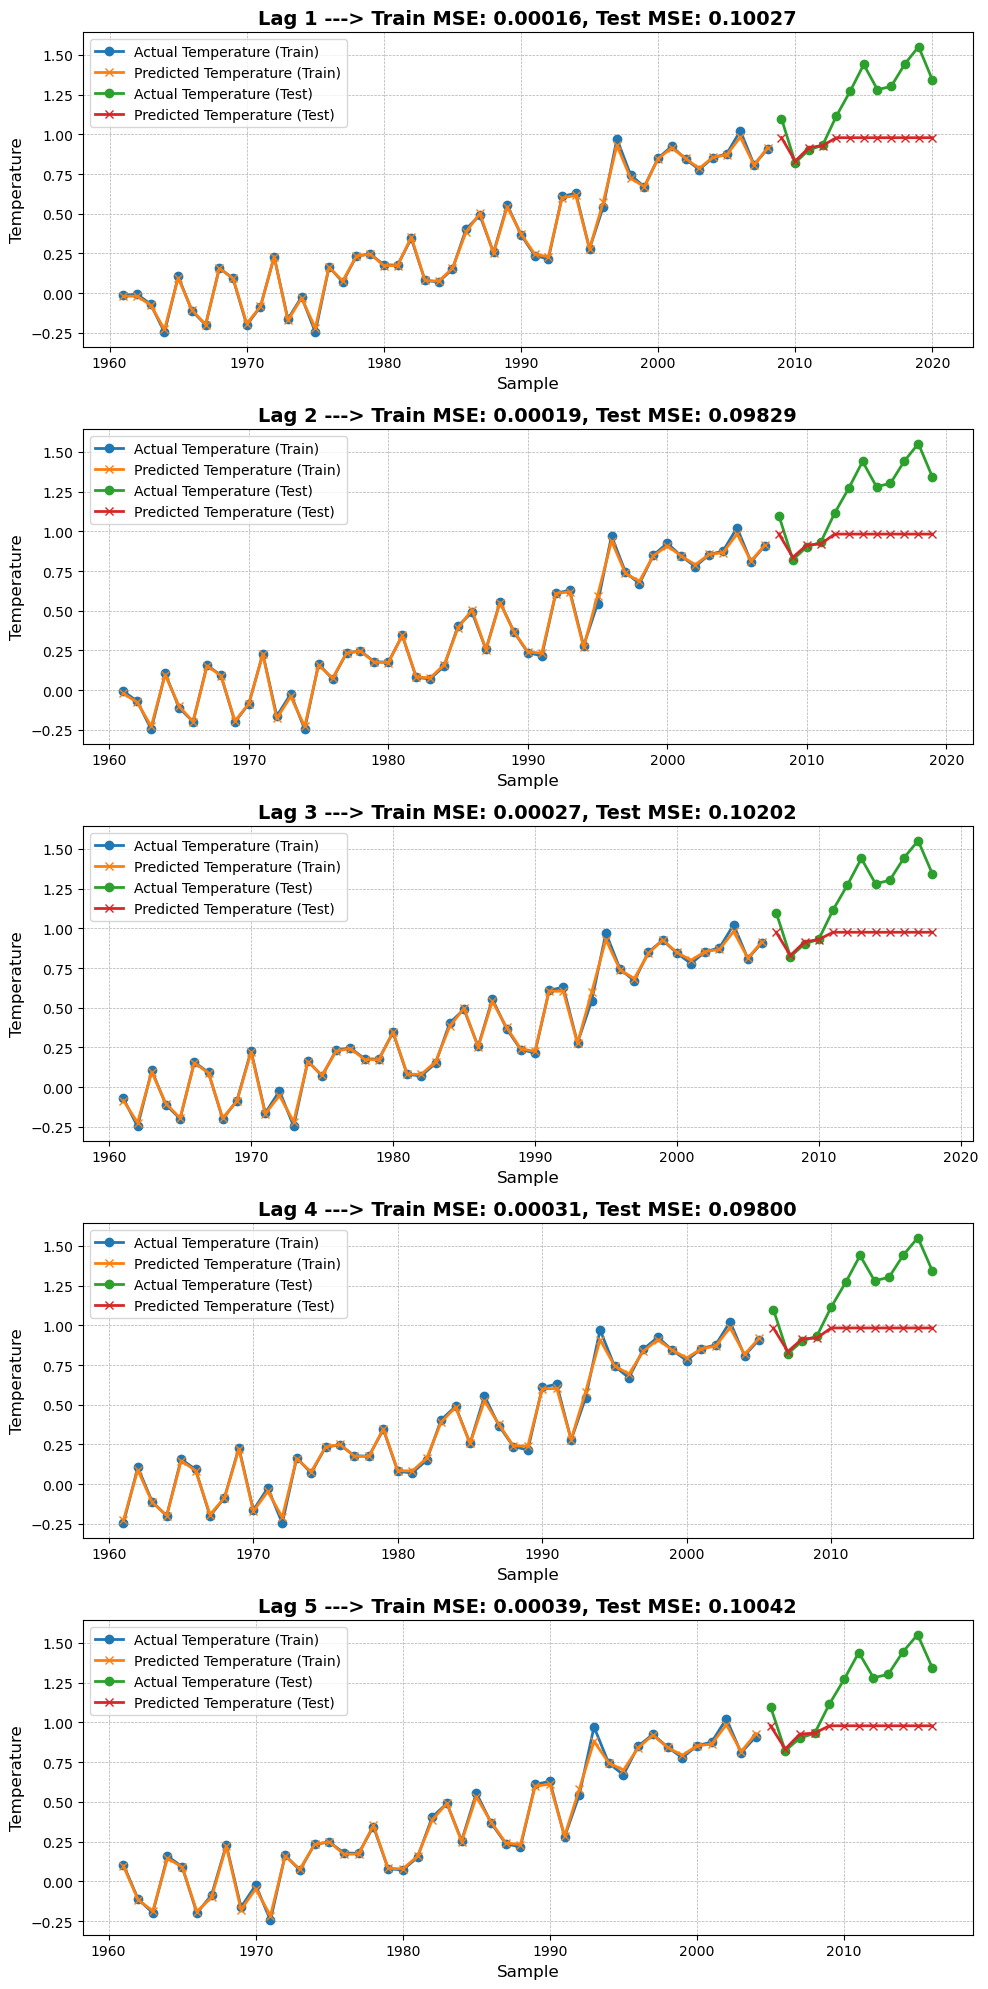

In [46]:
# Define the list of lags to consider
lags = [1, 2, 3, 4, 5]

# Create subplots with len(lags) rows and 1 column, and set the figure size
fig, ax = plt.subplots(len(lags), 1, figsize=(10, 20))

# Loop through each lag value and perform the Random Forest modeling and predictions
for lag in lags:
    # Create lagged input and output data
    X_lagged = np.zeros((len(X) - lag, lag * X.shape[1]))
    y_lagged = np.zeros(len(y) - lag)

    for i in range(lag, len(X)):
        X_lagged[i - lag] = X[i - lag:i].flatten()
        y_lagged[i - lag] = y[i]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_lagged, test_size=0.2, shuffle=False)

    # Normalize the input features X_train and X_test using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Combine lagged target variable with the input features
    X_train_rf = np.concatenate((X_train_scaled, y_train.reshape(-1, 1)), axis=1)
    X_test_rf = np.concatenate((X_test_scaled, y_test.reshape(-1, 1)), axis=1)

    # Create and fit the Random Forest model
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_train_rf, y_train)

    # Make predictions on the training set
    y_pred_train = rf.predict(X_train_rf)
    mse_train = mean_squared_error(y_train, y_pred_train)

    # Make predictions on the test set
    y_pred_test = rf.predict(X_test_rf)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Plot the predictions on the training set
    train_index = range(len(y_train))
    ax[lag - 1].plot(data['Year'][train_index], y_train, label='Actual Temperature (Train)', linewidth=2, marker="o")
    ax[lag - 1].plot(data['Year'][train_index], y_pred_train, label='Predicted Temperature (Train)', linewidth=2, marker="x")

    # Plot the predictions on the test set
    test_index = range(len(y_train), len(y_train) + len(y_pred_test))
    ax[lag - 1].plot(data['Year'][test_index], y_test, label='Actual Temperature (Test)', linewidth=2, marker="o")
    ax[lag - 1].plot(data['Year'][test_index], y_pred_test, label='Predicted Temperature (Test)', linewidth=2, marker="x")

    # Set plot properties
    ax[lag - 1].set_xlabel('Sample', fontsize=12)
    ax[lag - 1].set_ylabel('Temperature', fontsize=12)
    ax[lag - 1].set_title(f"Lag {lag} ---> Train MSE: {mse_train:.5f}, Test MSE: {mse_test:.5f}", fontsize=14, fontweight='bold')
    ax[lag - 1].legend(loc='upper left', fontsize=10)
    ax[lag - 1].tick_params(axis='both', which='major', labelsize=10)
    ax[lag - 1].grid(True, linestyle='--', linewidth=0.5)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 772ms/step


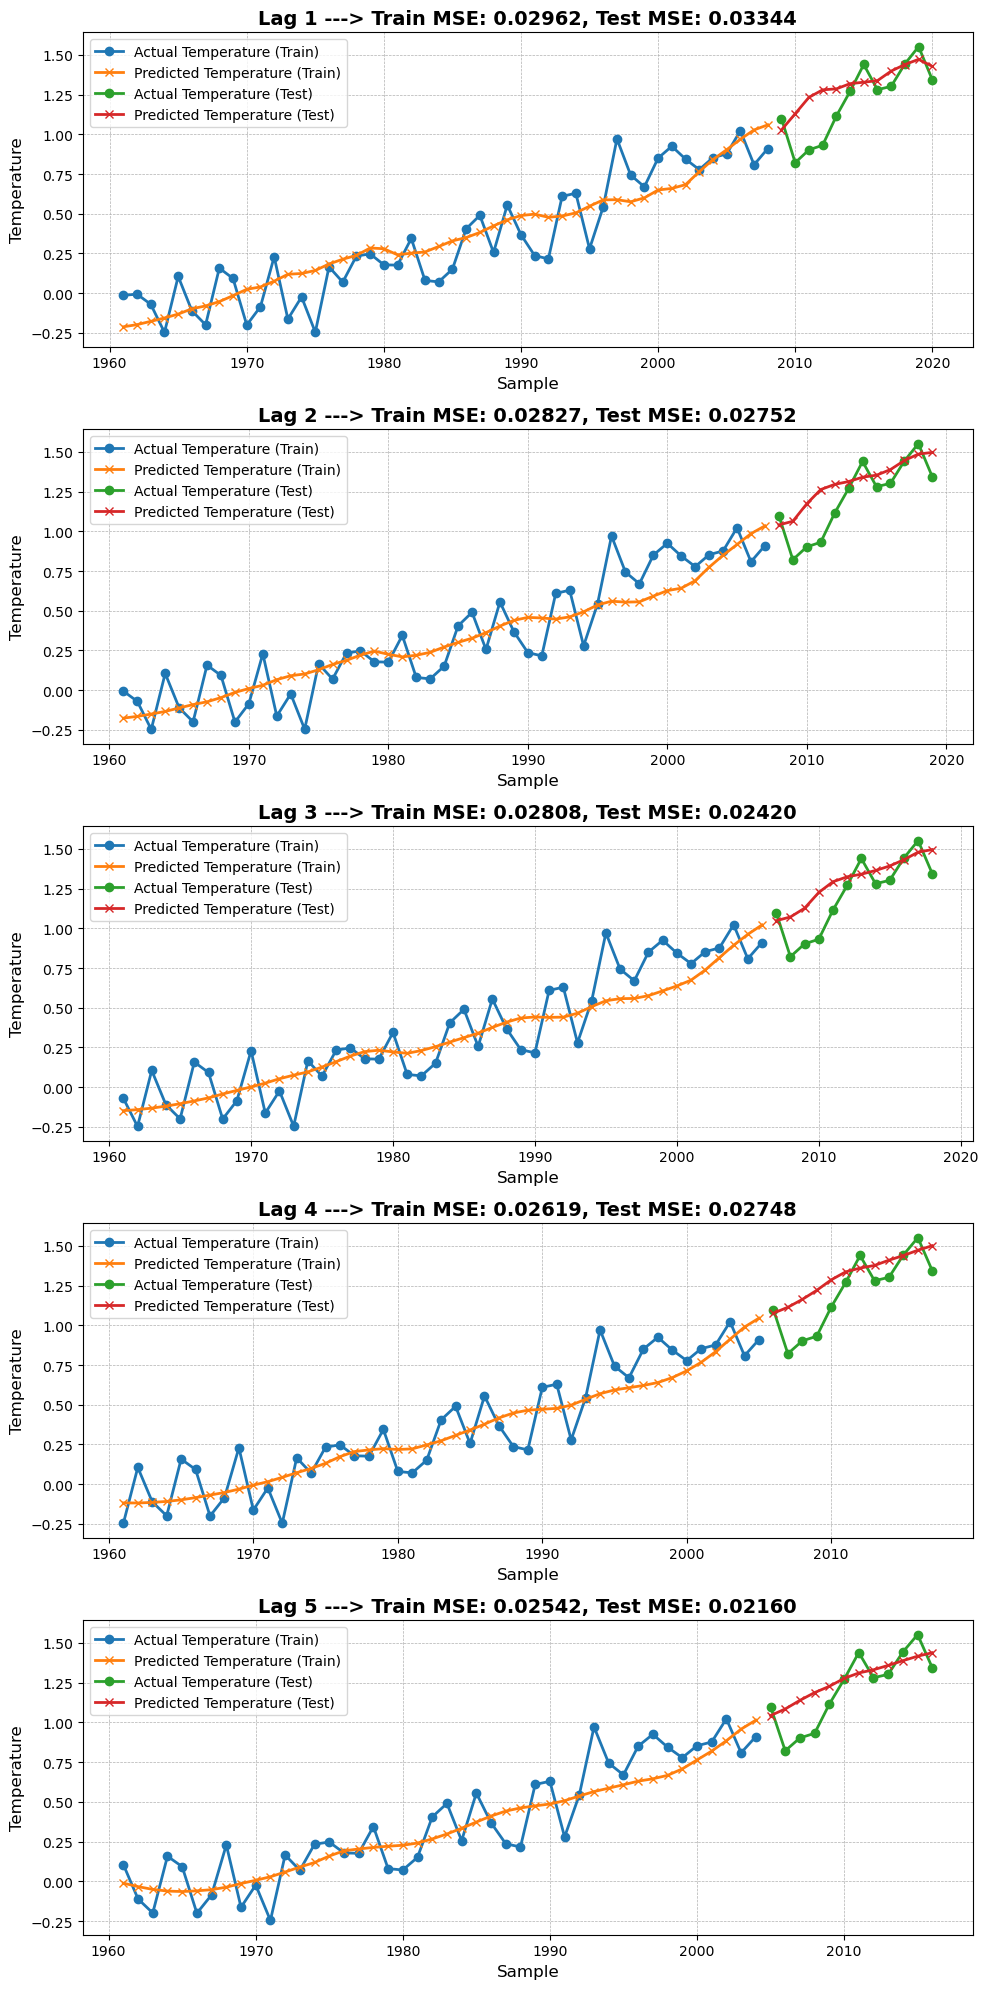

In [47]:
# Define the list of lags to consider
lags = [1, 2, 3, 4, 5]

# Create subplots with len(lags) rows and 1 column, and set the figure size
fig, ax = plt.subplots(len(lags), 1, figsize=(10, 20))

# Loop through each lag value and perform LSTM modeling and predictions
for lag in lags:
    # Create lagged input and output data
    X_lagged = np.zeros((len(X) - lag, lag * X.shape[1]))
    y_lagged = np.zeros(len(y) - lag)

    for i in range(lag, len(X)):
        X_lagged[i - lag] = X[i - lag:i].flatten()
        y_lagged[i - lag] = y[i]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_lagged, test_size=0.2, shuffle=False)

    # Normalize the input features X_train and X_test using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the input data for LSTM (samples, timesteps, features)
    X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], lag, X.shape[1])
    X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], lag, X.shape[1])

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(lag, X.shape[1])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit the LSTM model
    model.fit(X_train_lstm, y_train, epochs=50, batch_size=1, verbose=0)

    # Make predictions on the training set
    y_pred_train = model.predict(X_train_lstm)
    mse_train = mean_squared_error(y_train, y_pred_train)

    # Make predictions on the test set
    y_pred_test = model.predict(X_test_lstm)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Plot the predictions on the training set
    train_index = range(len(y_train))
    ax[lag - 1].plot(data['Year'][train_index], y_train, label='Actual Temperature (Train)', linewidth=2, marker="o")
    ax[lag - 1].plot(data['Year'][train_index], y_pred_train, label='Predicted Temperature (Train)', linewidth=2, marker="x")

    # Plot the predictions on the test set
    test_index = range(len(y_train), len(y_train) + len(y_pred_test))
    ax[lag - 1].plot(data['Year'][test_index], y_test, label='Actual Temperature (Test)', linewidth=2, marker="o")
    ax[lag - 1].plot(data['Year'][test_index], y_pred_test, label='Predicted Temperature (Test)', linewidth=2, marker="x")

    # Set plot properties
    ax[lag - 1].set_xlabel('Sample', fontsize=12)
    ax[lag - 1].set_ylabel('Temperature', fontsize=12)
    ax[lag - 1].set_title(f"Lag {lag} ---> Train MSE: {mse_train:.5f}, Test MSE: {mse_test:.5f}", fontsize=14, fontweight='bold')
    ax[lag - 1].legend(loc='upper left', fontsize=10)
    ax[lag - 1].tick_params(axis='both', which='major', labelsize=10)
    ax[lag - 1].grid(True, linestyle='--', linewidth=0.5)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


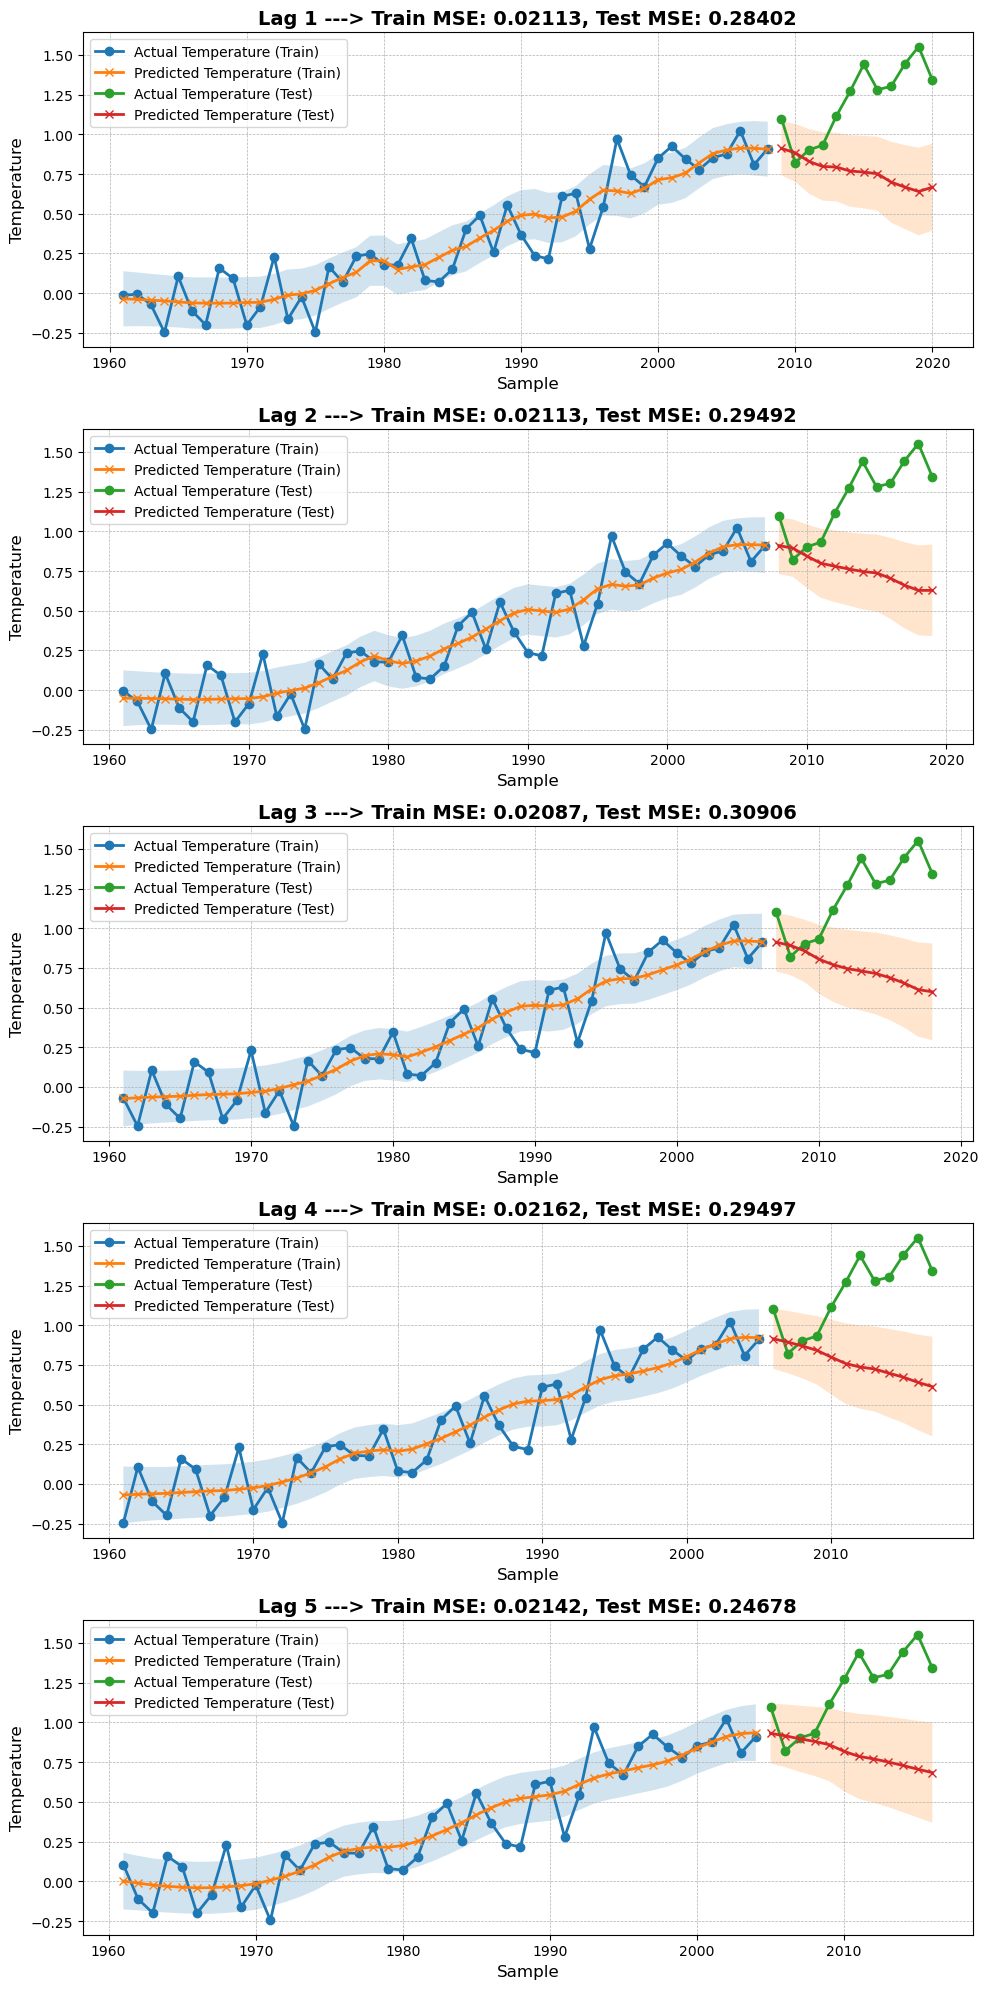

In [48]:
# Define the list of lags to consider
lags = [1, 2, 3, 4, 5]

# Create subplots with len(lags) rows and 1 column, and set the figure size
fig, ax = plt.subplots(len(lags), 1, figsize=(10, 20))

# Loop through each lag value and perform Gaussian Process modeling and predictions
for lag in lags:
    # Create lagged input and output data
    X_lagged = np.zeros((len(X) - lag, lag * X.shape[1]))
    y_lagged = np.zeros(len(y) - lag)

    for i in range(lag, len(X)):
        X_lagged[i - lag] = X[i - lag:i].flatten()
        y_lagged[i - lag] = y[i]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_lagged, test_size=0.2, shuffle=False)

    # Normalize the input features X_train and X_test using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create the Gaussian Process model with RBF kernel
    kernel = 1.0 * RBF() + WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    # Fit the Gaussian Process model
    gp.fit(X_train_scaled, y_train)

    # Make predictions on the training set
    y_pred_train, std_train = gp.predict(X_train_scaled, return_std=True)
    mse_train = mean_squared_error(y_train, y_pred_train)

    # Make predictions on the test set
    y_pred_test, std_test = gp.predict(X_test_scaled, return_std=True)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Plot the predictions on the training set
    train_index = range(len(y_train))
    ax[lag - 1].plot(data['Year'][train_index], y_train, label='Actual Temperature (Train)', linewidth=2, marker="o")
    ax[lag - 1].plot(data['Year'][train_index], y_pred_train, label='Predicted Temperature (Train)', linewidth=2, marker="x")
    ax[lag - 1].fill_between(data['Year'][train_index], y_pred_train - std_train, y_pred_train + std_train, alpha=0.2)

    # Plot the predictions on the test set
    test_index = range(len(y_train), len(y_train) + len(y_pred_test))
    ax[lag - 1].plot(data['Year'][test_index], y_test, label='Actual Temperature (Test)', linewidth=2, marker="o")
    ax[lag - 1].plot(data['Year'][test_index], y_pred_test, label='Predicted Temperature (Test)', linewidth=2, marker="x")
    ax[lag - 1].fill_between(data['Year'][test_index], y_pred_test - std_test, y_pred_test + std_test, alpha=0.2)

    # Set plot properties
    ax[lag - 1].set_xlabel('Sample', fontsize=12)
    ax[lag - 1].set_ylabel('Temperature', fontsize=12)
    ax[lag - 1].set_title(f"Lag {lag} ---> Train MSE: {mse_train:.5f}, Test MSE: {mse_test:.5f}", fontsize=14, fontweight='bold')
    ax[lag - 1].legend(loc='upper left', fontsize=10)
    ax[lag - 1].tick_params(axis='both', which='major', labelsize=10)
    ax[lag - 1].grid(True, linestyle='--', linewidth=0.5)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


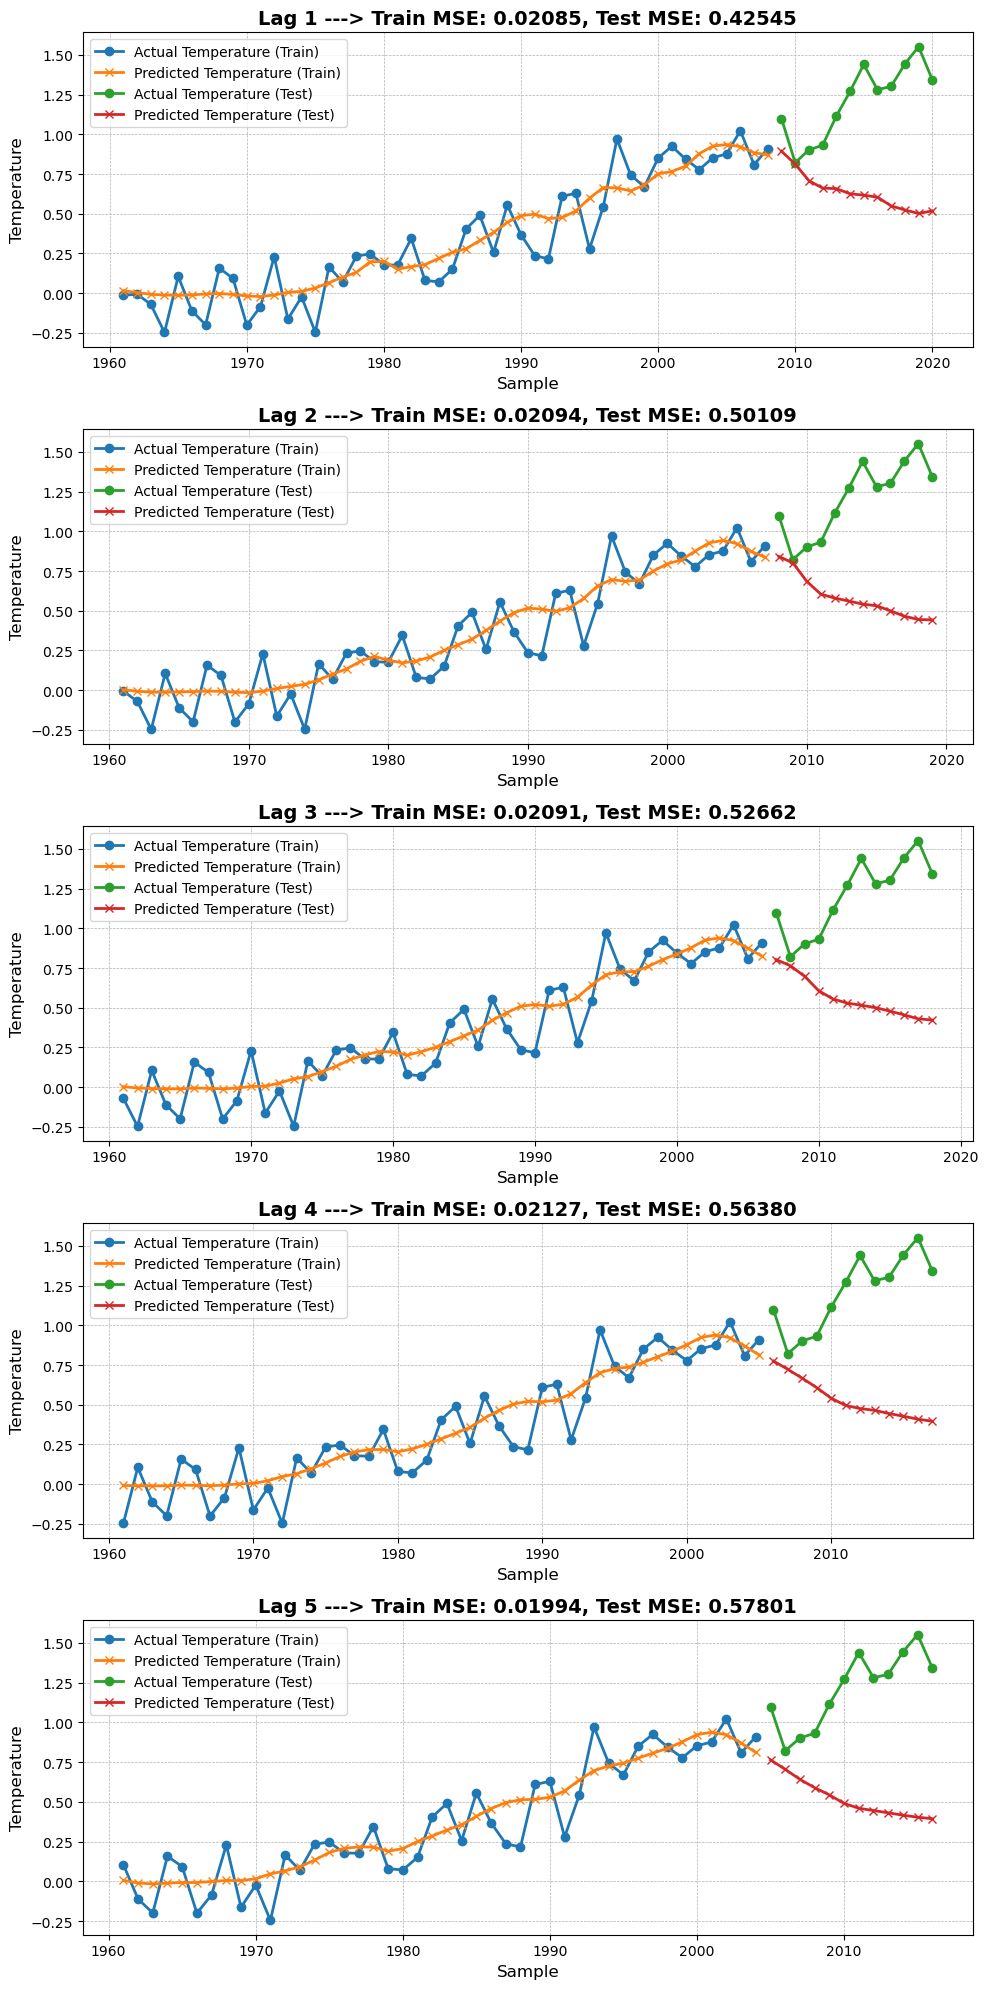

In [52]:
# Define the list of lags to consider
lags = [1, 2, 3, 4, 5]

# Create subplots with len(lags) rows and 1 column, and set the figure size
fig, ax = plt.subplots(len(lags), 1, figsize=(10, 20))

# Loop through each lag value and perform Support Vector Regression (SVR) modeling and predictions
for lag in lags:
    # Create lagged input and output data
    X_lagged = np.zeros((len(X) - lag, lag * X.shape[1]))
    y_lagged = np.zeros(len(y) - lag)

    for i in range(lag, len(X)):
        X_lagged[i - lag] = X[i - lag:i].flatten()
        y_lagged[i - lag] = y[i]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_lagged, test_size=0.2, shuffle=False)

    # Normalize the input features X_train and X_test using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create the Support Vector Regression (SVR) model with a radial basis function (RBF) kernel
    svr = SVR(kernel='rbf')

    # Fit the SVR model
    svr.fit(X_train_scaled, y_train)

    # Make predictions on the training set
    y_pred_train = svr.predict(X_train_scaled)
    mse_train = mean_squared_error(y_train, y_pred_train)

    # Make predictions on the test set
    y_pred_test = svr.predict(X_test_scaled)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Plot the predictions on the training set
    train_index = range(len(y_train))
    ax[lag - 1].plot(data['Year'][train_index], y_train, label='Actual Temperature (Train)', linewidth=2, marker="o")
    ax[lag - 1].plot(data['Year'][train_index], y_pred_train, label='Predicted Temperature (Train)', linewidth=2, marker="x")

    # Plot the predictions on the test set
    test_index = range(len(y_train), len(y_train) + len(y_pred_test))
    ax[lag - 1].plot(data['Year'][test_index], y_test, label='Actual Temperature (Test)', linewidth=2, marker="o")
    ax[lag - 1].plot(data['Year'][test_index], y_pred_test, label='Predicted Temperature (Test)', linewidth=2, marker="x")

    ax[lag - 1].set_xlabel('Sample', fontsize=12)
    ax[lag - 1].set_ylabel('Temperature', fontsize=12)
    ax[lag - 1].set_title(f"Lag {lag} ---> Train MSE: {mse_train:.5f}, Test MSE: {mse_test:.5f}", fontsize=14, fontweight='bold')
    ax[lag - 1].legend(loc='upper left', fontsize=10)
    ax[lag - 1].tick_params(axis='both', which='major', labelsize=10)
    ax[lag - 1].grid(True, linestyle='--', linewidth=0.5)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 147ms/step


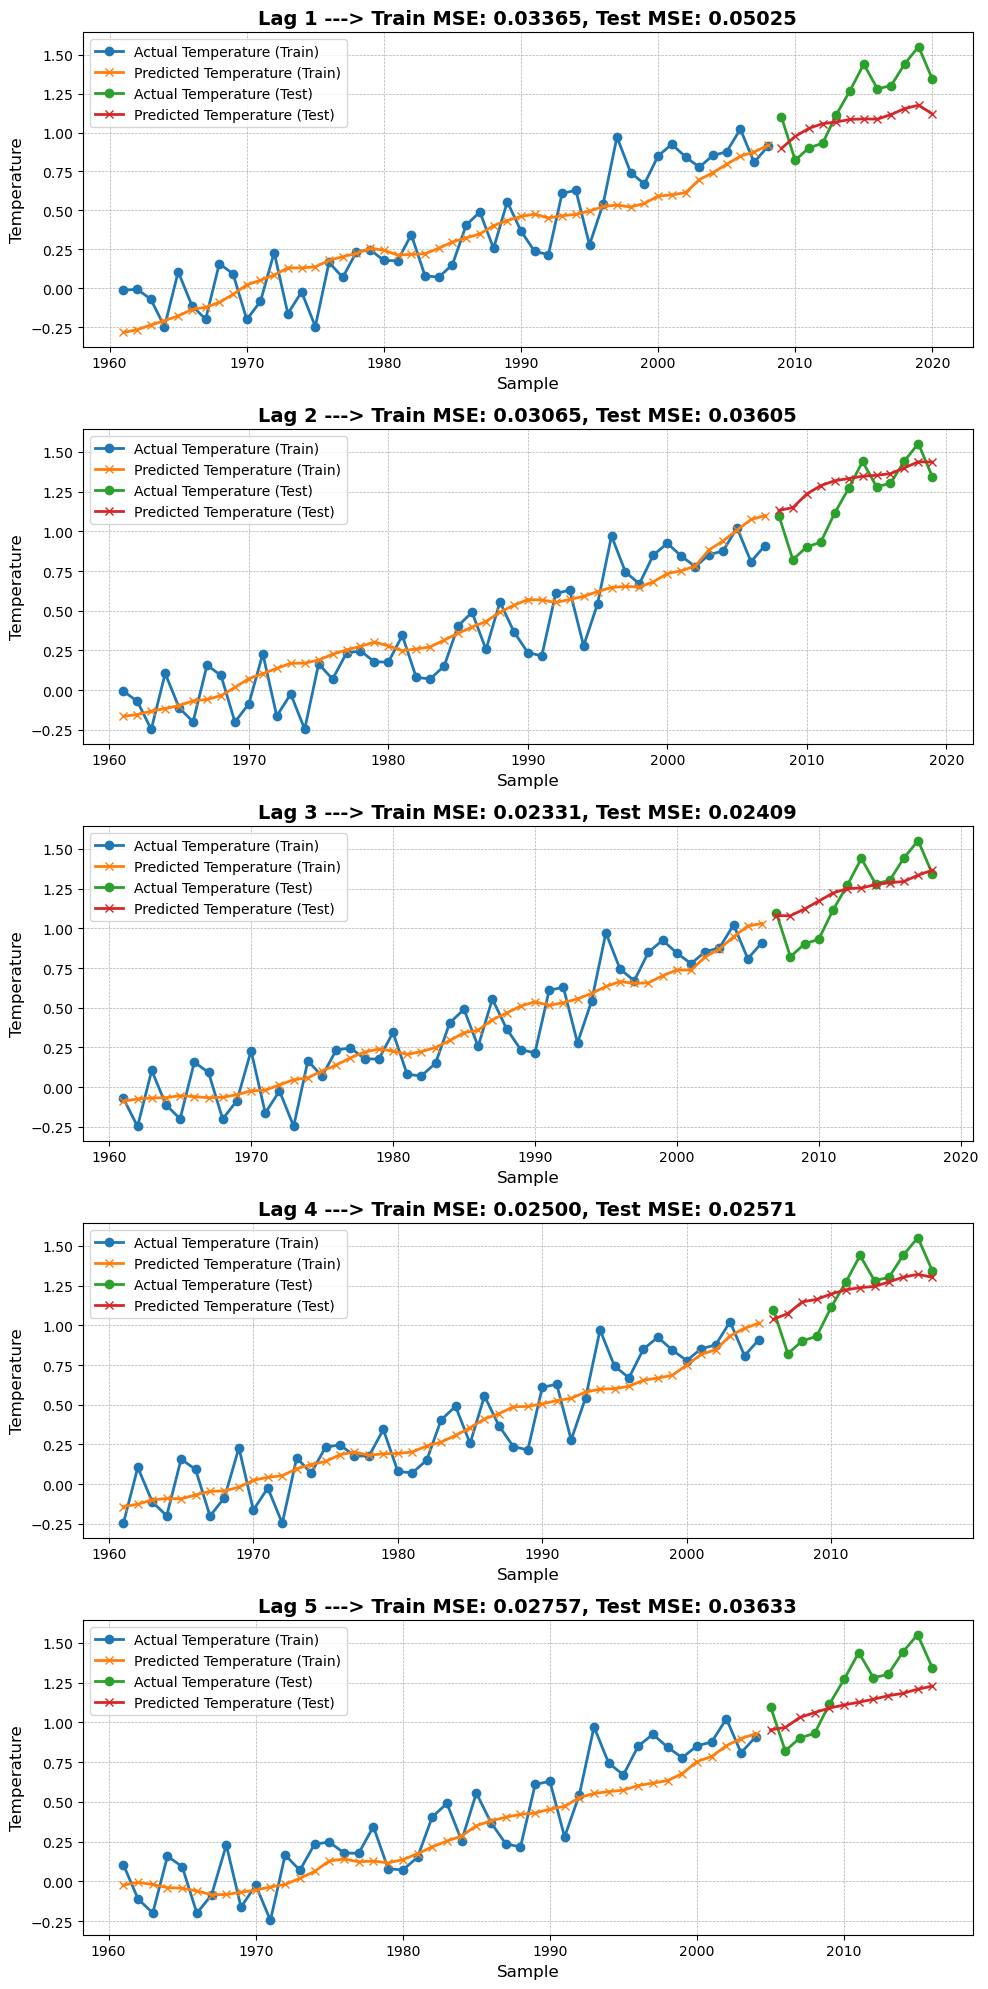

In [53]:
# Define the list of lags to consider
lags = [1, 2, 3, 4, 5]

# Create subplots with len(lags) rows and 1 column, and set the figure size
fig, ax = plt.subplots(len(lags), 1, figsize=(10, 20))

# Loop through each lag value and perform SimpleRNN modeling and predictions
for lag in lags:
    # Create lagged input and output data
    X_lagged = np.zeros((len(X) - lag, lag * X.shape[1]))
    y_lagged = np.zeros(len(y) - lag)

    for i in range(lag, len(X)):
        X_lagged[i - lag] = X[i - lag:i].flatten()
        y_lagged[i - lag] = y[i]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_lagged, test_size=0.2, shuffle=False)

    # Normalize the input features X_train and X_test using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the input data for SimpleRNN (samples, timesteps, features)
    X_train_rnn = X_train_scaled.reshape(X_train_scaled.shape[0], lag, X.shape[1])
    X_test_rnn = X_test_scaled.reshape(X_test_scaled.shape[0], lag, X.shape[1])

    # Build the SimpleRNN model
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(lag, X.shape[1])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit the SimpleRNN model
    model.fit(X_train_rnn, y_train, epochs=50, batch_size=1, verbose=0)

    # Make predictions on the training set
    y_pred_train = model.predict(X_train_rnn)
    mse_train = mean_squared_error(y_train, y_pred_train)

    # Make predictions on the test set
    y_pred_test = model.predict(X_test_rnn)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Plot for prediction on the training set
    train_index = range(len(y_train))
    ax[lag - 1].plot(data['Year'][train_index], y_train, label='Actual Temperature (Train)', linewidth=2, marker="o")
    ax[lag - 1].plot(data['Year'][train_index], y_pred_train, label='Predicted Temperature (Train)', linewidth=2, marker="x")

    # Plot for prediction on the test set
    test_index = range(len(y_train), len(y_train) + len(y_pred_test))
    ax[lag - 1].plot(data['Year'][test_index], y_test, label='Actual Temperature (Test)', linewidth=2, marker="o")
    ax[lag - 1].plot(data['Year'][test_index], y_pred_test, label='Predicted Temperature (Test)', linewidth=2, marker="x")

    ax[lag - 1].set_xlabel('Sample', fontsize=12)
    ax[lag - 1].set_ylabel('Temperature', fontsize=12)
    ax[lag - 1].set_title(f"Lag {lag} ---> Train MSE: {mse_train:.5f}, Test MSE: {mse_test:.5f}", fontsize=14, fontweight='bold')
    ax[lag - 1].legend(loc='upper left', fontsize=10)
    ax[lag - 1].tick_params(axis='both', which='major', labelsize=10)
    ax[lag - 1].grid(True, linestyle='--', linewidth=0.5)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()
